# Reading EMEP data with pyaerocom

This notebook give a short intro to reading EMEP data with pyaerocom and gives an example of running an evaluation against EBAS observations.

If you are unfamiliar with pyaerocom it is suggested to first go through the [getting started tutorial](./getting_started_setup.ipynb).

In [1]:
import pyaerocom as pya

First we make sure the pyaerocom testdata is downloaded.

In [2]:
from pyaerocom.testdata_access import TestDataAccess
TestDataAccess().download()

True

The testdata contains EMEP data from the 2018 report, which has been regridded to reduce file size.
<br>Monthly data is regridded to 3x3.
<br>Daily data is regridded to 10x10.

## File convention

PyAerocom understands the following file conventions for EMEP data:
- Base_hour.nc - Hourly resolution
- Base_day.nc - Daily resolution
- Base_month.nc - Monthly resolution
- Base_fullrun.nc - Yearly resolution

It is expected that each file contains at most one year of data.
Each file can contain several variables. The mapping between EMEP and pyaerocom variable names is available in the [pyaerocom github repository](https://github.com/metno/pyaerocom/blob/master/pyaerocom/data/emep_variables.ini).

In [3]:
dataloc = f'{pya.const.HOMEDIR}MyPyaerocom/testdata-minimal/'
emep_dir = dataloc + 'modeldata/EMEP_rep'

In [4]:
import os; os.listdir(emep_dir)

['unconventional.nc', 'Base_day.nc', 'Base_month.nc']

There are three available files. Two of them are in the file convention that PyAerocom understands, in daily and monthly resolution.

## Reading conventionally named data

We start by reading the data with the PyAerocom-friendly convention.<br>
Initialize reader and point it to the right folder:

In [5]:
reader = pya.io.ReadMscwCtm(data_id='EMEP_rep20', data_dir=emep_dir)
print(reader)

Reader: ReadMscwCtm
Available frequencies: ['monthly', 'daily']
Available variables: ['concno2', 'concpm10', 'concpm25', 'vmro3']



In [6]:
reader.years_avail

[2018]

Both files are from 2018.<br>
We can read one of the variables and make a basic map.<br>
Note that we specify the temporal resolution with ts_type, which will ensure the right file is loaded.

In [7]:
data = reader.read_var('vmro3', ts_type='monthly')
data

pyaerocom.GriddedData
Grid data: <iris 'Cube' of vmro3 / (ppb) (time: 12; latitude: 60; longitude: 120)>

Data is a GriddedData object, see more in the [getting started tutorial.](./getting_started_analysis.ipynb)

/home/eirikg/miniconda3/envs/pya/lib/python3.8/site-packages/iris/coords.py:1192: UserWarning: Coordinate 'longitude' is not bounded, guessing contiguous bounds.
  warnings.warn('Coordinate {!r} is not bounded, guessing '
/home/eirikg/miniconda3/envs/pya/lib/python3.8/site-packages/iris/coords.py:1192: UserWarning: Coordinate 'latitude' is not bounded, guessing contiguous bounds.
  warnings.warn('Coordinate {!r} is not bounded, guessing '
/home/eirikg/miniconda3/envs/pya/lib/python3.8/site-packages/iris/analysis/cartography.py:394: UserWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn("Using DEFAULT_SPHERICAL_EARTH_RADIUS.")


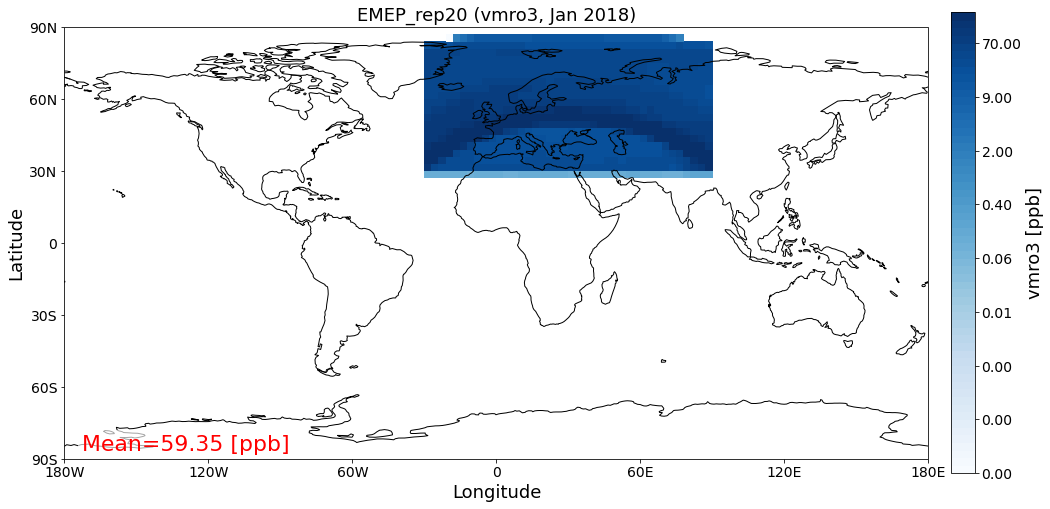

In [8]:
data.quickplot_map(0);

## Reading unconventionally named data

To read the unconventionally named file we specify the path to the file instead of the whole directory.

In [9]:
reader = pya.io.ReadMscwCtm(data_id='EMEP', filepath=emep_dir + '/unconventional.nc')
print(reader)

Reader: ReadMscwCtm
Available frequencies: [None]
Available variables: ['concno2', 'concpm10', 'concpm25', 'vmro3']



The file contains the same variables as the other, but the frequency could not be inferred.<br>
Since we know it has yearly resolution we can read it with:

In [10]:
data = reader.read_var('concpm10', ts_type='yearly')
data

pyaerocom.GriddedData
Grid data: <iris 'Cube' of concpm10 / (ug/m3) (time: 1; latitude: 60; longitude: 120)>

## Colocating data

The testdata which contains both the EMEP example data and a subset of the EBAS dataset is initialized.

In [11]:
from pyaerocom.testdata_access import initialise
initialise()

Adding data search directory /home/eirikg/MyPyaerocom/testdata-minimal/modeldata.
Adding data search directory /home/eirikg/MyPyaerocom/testdata-minimal/obsdata.
Adding data search directory /home/eirikg/MyPyaerocom/testdata-minimal/config.
Adding ungridded dataset AeronetSunV3L2Subset.daily located at /home/eirikg/MyPyaerocom/testdata-minimal/obsdata/AeronetSunV3Lev2.daily/renamed.Reader: <class 'pyaerocom.io.read_aeronet_sunv3.ReadAeronetSunV3'>
Adding ungridded dataset AeronetSDAV3L2Subset.daily located at /home/eirikg/MyPyaerocom/testdata-minimal/obsdata/AeronetSDAV3Lev2.daily/renamed.Reader: <class 'pyaerocom.io.read_aeronet_sdav3.ReadAeronetSdaV3'>
Adding ungridded dataset AeronetInvV3L2Subset.daily located at /home/eirikg/MyPyaerocom/testdata-minimal/obsdata/AeronetInvV3Lev2.daily/renamed.Reader: <class 'pyaerocom.io.read_aeronet_invv3.ReadAeronetInvV3'>
Adding ungridded dataset EBASSubset located at /home/eirikg/MyPyaerocom/testdata-minimal/obsdata/EBASMultiColumn.Reader: <clas

Load the EBAS concpm10 data.

In [12]:
var_name='concpm10'
r = pya.io.ReadUngridded('EBASSubset')
data_ebas = r.read(vars_to_retrieve=var_name)

newest_file_date_in_read_dir is outdated (value: 1608211788.2272425). Current value: 1608293941.59473
Deleting outdated cache file: /home/eirikg/MyPyaerocom/_cache/eirikg/EBASSubset_concpm10.pkl
Reading EBAS data
100%|██████████| 4/4 [00:00<00:00, 93.45it/s]


Plot timeseries for all available stations.

Ignoring multiplication factor 30 in data with resolution 30minutely in resampling method
/home/eirikg/Desktop/pyaerocom/pyaerocom/pyaerocom/helpers.py:1036: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[how][invalid] = np.nan


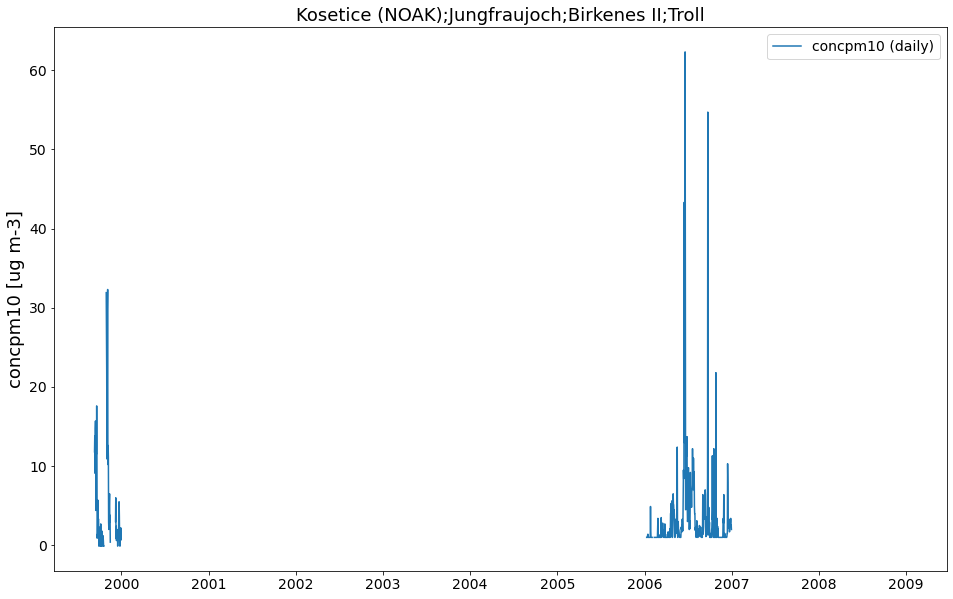

In [13]:
data_ebas.plot_station_timeseries('*', var_name=var_name);

Since we don't have any 2018 data in the EBAS subset we load the EMEP data and change it's year.

In [14]:
reader = pya.io.ReadMscwCtm(data_id='EMEP', data_dir=emep_dir)
data_emep = reader.read_var(var_name, ts_type='monthly')
data_emep.change_base_year(2006, inplace=True);

And we can colocate `data_emep` and `data_ebas`.

Input filters {'latitude': [-88.5, 88.5], 'longitude': [-178.5, 178.5]} result in unchanged data object
/home/eirikg/Desktop/pyaerocom/pyaerocom/pyaerocom/helpers.py:1036: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[how][invalid] = np.nan


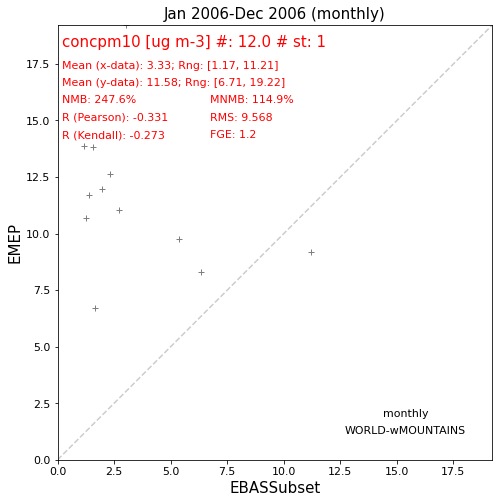

In [15]:
coldata = pya.colocation.colocate_gridded_ungridded(data_emep, data_ebas,
                                                    filter_name='WORLD-wMOUNTAINS');
coldata.plot_scatter();

And we get a scatter plot and statistics of the colocated data.<br>
The match between the observations and model are not good here, which is expected since we are comparing different years.